# Study Design

## Goals and Requirements
The goal of this study is to ascertain the 
- rate
- conditions (time lapsed, questions asked)
- common topics in which
a change from a mostly asking user to an actively answering one can occur
### Requirements:
For this study the open kaggle dataset of stackoverflow (150GB, 2 years old) will be used (out of convenience) and will thus require access to Googles BigQuery API


assuming Windows and Conda:

```
pip install --upgrade google-cloud-bigquery
conda install -c anaconda git
pip install -e git+https://github.com/SohierDane/BigQuery_Helper#egg=bq_helper
```

## Study Questions
*Does it happen that a q-user becomes an a-user?*

Problems in finding the answer to this question:
- one needs to define a cutoff between "initial a-user" and "q-user convert"
- maybe there is an "early onset" of the conversion by increased commenting?
-- maybe its even more important that the q-user starts commenting on other peoples questions?
- users might be more eager to start answering questions if their questions where well received, i.e. they received a high number of votes and high quality accepted answers (using votes as a metric for the quality of the answer)
- it might be worthwile to investigate other network sites on stackexchange: A user might only ask questions  on stackoverflow, but answer questions on math.stackexchange. This behaviour might influence wether or not the user will start answering questions on stackoverflow

## Research Method
Investigate a reasonably sized, random sample taken from the dataset, use visualisation methods and descriptive statistics to investigate trends and structure, use these insights to build a predictive model and evaluate its performance on a test set taken out of the same dataset

## Strategy
If possible, use the dataset on kaggle as a source for our data.
Decide on a resonable size of the dataset which we will consider for further analysis; using the entire dataset (let alone the *real* entire live dataset until ~2018) will not be feasible.

Start by seperating out a sample from the dataset which will later be used to evaluate performance.

For some of the required data, it might be neccesary to use stackAPI to gather additional data e.g. stats on other network sites.

# Data Retrieval

In [66]:
'''
import os
import bq_helper
from bq_helper import BigQueryHelper

credential_path ="./bigquery_key.json"
#^this json can be generated follwoing these instructions: https://cloud.google.com/bigquery/docs/reference/libraries 
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credential_path
stackOverflow=bq_helper.BigQueryHelper(active_project="bigquery-public-data",dataset_name="stackoverflow")
bq_assistant = BigQueryHelper("bigquery-public-data", "stackoverflow")
query="""

	SELECT questions.id as POST_ID, creation_date, answer_count,comment_count,score 
	FROM
		`bigquery-public-data.stackoverflow.posts_questions` questions
	WHERE questions.owner_user_id IN (SELECT answeres.owner_user_id 
            FROM `bigquery-public-data.stackoverflow.posts_answers` answeres) 
        """
#more useful:
q2="""
SELECT owner_antw, anzahl_fragen, avg_score_frage, min_date_frage, anzahl_antw, avg_score_antw, min_date_antw 
FROM ((SELECT owner_user_id as owner_frage, COUNT(*) AS anzahl_fragen, AVG(score) AS avg_score_frage, MIN(creation_date) as min_date_frage
	FROM
		`bigquery-public-data.stackoverflow.posts_questions` question
		GROUP BY
		owner_user_id)
	FULL OUTER JOIN
	(SELECT owner_user_id as owner_antw, COUNT(*) AS anzahl_antw, AVG(score) AS avg_score_antw, MIN(creation_date) as min_date_antw
		FROM
		`bigquery-public-data.stackoverflow.posts_answers` answers
		GROUP BY
		owner_user_id)
	ON owner_frage=owner_antw)
	
        """


print(bq_assistant.estimate_query_size(q2))

res= bq_assistant.query_to_pandas_safe(q2)
print("working")
res.to_csv("./q_a_users.csv")
print("done")
#other helpful links:
#https://www.kaggle.com/sohier/introduction-to-the-bq-helper-package#
#https://www.kaggle.com/paultimothymooney/how-to-query-the-stack-overflow-data#
'''

'\nimport os\nimport bq_helper\nfrom bq_helper import BigQueryHelper\n\ncredential_path ="./bigquery_key.json"\n#^this json can be generated follwoing these instructions: https://cloud.google.com/bigquery/docs/reference/libraries \nos.environ[\'GOOGLE_APPLICATION_CREDENTIALS\'] = credential_path\nstackOverflow=bq_helper.BigQueryHelper(active_project="bigquery-public-data",dataset_name="stackoverflow")\nbq_assistant = BigQueryHelper("bigquery-public-data", "stackoverflow")\nquery="""\n\n\tSELECT questions.id as POST_ID, creation_date, answer_count,comment_count,score \n\tFROM\n\t\t`bigquery-public-data.stackoverflow.posts_questions` questions\n\tWHERE questions.owner_user_id IN (SELECT answeres.owner_user_id \n            FROM `bigquery-public-data.stackoverflow.posts_answers` answeres) \n        """\n#more useful:\nq2="""\nSELECT owner_antw, anzahl_fragen, avg_score_frage, min_date_frage, anzahl_antw, avg_score_antw, min_date_antw \nFROM ((SELECT owner_user_id as owner_frage, COUNT(*) 

In [5]:
import pandas as pd
import plotly
import numpy as np
import plotly.graph_objs as go
from plotly.offline import iplot
from string import ascii_letters
plotly.offline.init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
df = pandas.read_csv('./q_a_users.csv', low_memory=False)

In [97]:
df['anzahl_antw'].fillna(0, inplace=True)
df['anzahl_fragen'].fillna(0, inplace=True)
df['avg_score_antw'].fillna(0.0, inplace=True)
df['avg_score_frage'].fillna(0.0, inplace=True)

In [51]:
df = df[df.columns[1:]] # drop redundant id column

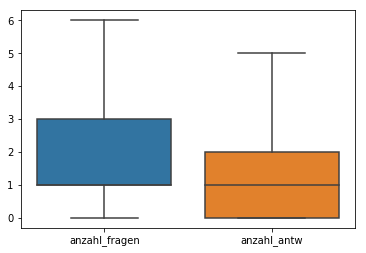

In [52]:
sns.boxplot(data=df[['anzahl_fragen', 'anzahl_antw']], sym='')

### Testing that 'converted' q-users do exist:
This study can only work if all three groups:
- q-user: that to this day have not answered a question
- a-user: that to this day have not asked a question
- converts: former q-users
exist in significant numbers in the datasample.
In this case a destinction were made if at least one day between a question asked and one answered lapsed or not (so "both" does ask and answere on the same day )

In [62]:
dff=df.dropna()
day_diff=np.array([int(i.days) for i in (pd.to_datetime(dff['min_date_frage'])-pd.to_datetime(dff['min_date_antw']))])
dff['days']=day_diff
#print(timedifference)
dff=dff.sort_values('days', ascending=True)
dff["days_sign"] = np.sign(dff.days)
dff['days'].describe()

/home/simon/.conda/envs/conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



count    1.167083e+06
mean    -8.824696e+01
std      4.710262e+02
min     -3.620000e+03
25%     -1.610000e+02
50%     -6.000000e+00
75%      0.000000e+00
max      3.675000e+03
Name: days, dtype: float64

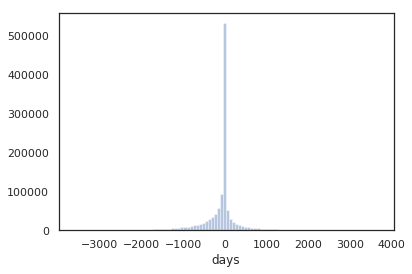

In [71]:
import scipy
sns.distplot(dff['days'], bins=100, kde=False)

This bar shows that most people, if they both ask and answer, answer a question first and within days ask their first question.

In [20]:
s=dff['days_sign'].value_counts()
q_users = len(df[df['anzahl_antw'] == 0])
a_users = len(df[df['anzahl_fragen'] == 0 ])
mixed_users = len(df[(df['anzahl_fragen'] > 0) & (df['anzahl_antw'] > 0)])

iplot([
    go.Pie(labels=["Q-Users", "Pure A-Users", "Q to A (converts)", "A to Q", "both"], 
           values=[q_users, a_users,s[1],s[-1],s[0]])
])

So one can see the out of every user that both asked and answered:
- 867 559 people answer a question first
- 281 493 people ask one first -> converts!
- 18 031 do both in the same day

In [21]:
df['min_date_antw'] = pandas.to_datetime(df['min_date_antw'])
df['min_date_frage'] = pandas.to_datetime(df['min_date_frage'])

In [76]:
q_to_a = df[df['min_date_frage'] < df['min_date_antw']]
a_to_q = df[df['min_date_frage'] > df['min_date_antw']]

In [78]:
time_delta_q_to_a = q_to_a['min_date_antw'] - q_to_a['min_date_frage']
time_delta_a_to_q = a_to_q['min_date_frage'] - a_to_q['min_date_antw']

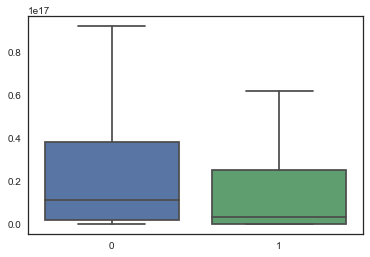

In [79]:
sns.boxplot(data=[time_delta_a_to_q, time_delta_q_to_a], sym='')

### Assuming basic correlations
If one gets consistently high scores they might answer more questions and vice versa.
Here the two corelations seperately and a plot showing a correlation matrix

In [88]:
#augment data with categorical data showing whether or not a user is an a-user
df['has_answer'] = [int(x) for x in df['anzahl_antw'] > 0]

In [80]:
df['anzahl_antw'].corr(df['avg_score_antw'])

0.005153025724105061

In [81]:
# without Nan:
dff['anzahl_antw'].corr(dff['avg_score_antw'])

0.023626097846844104

In [82]:
df['anzahl_fragen'].corr(df['avg_score_frage'])

0.0032931468003781243

In [86]:
df['anzahl_antw'].corr(df['has_answer'])

0.0506160267322129

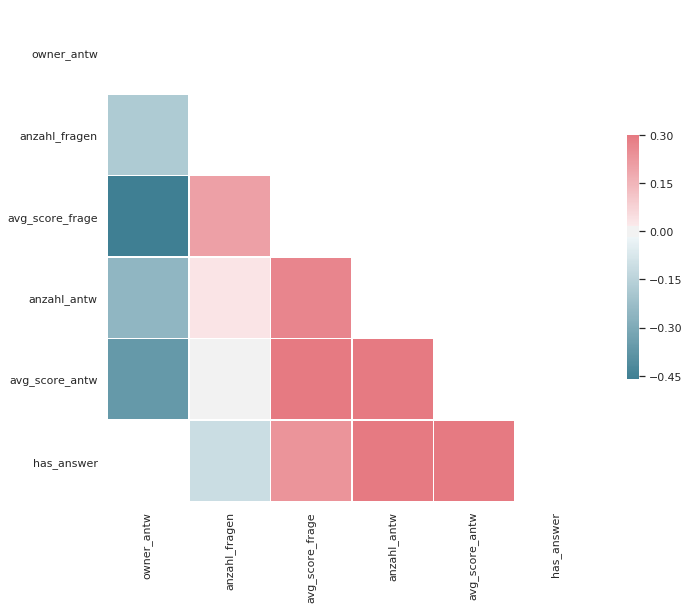

In [96]:
sns.set(style="white")

corr = df.corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

So no significant corelation can be found.

## Left to do:
- infestigate if and which parameters exist that can predict a "conversion" before it happens (new and slightly[severly] more complicated querry is needed) <br>
e.g. if a badge is earned for asking questions, could there be a corelation to start answering?<br>
- - build predictive models on findings
- investigate if the dataset is just a "window" of 2 years. Meaning it might be necessary to throw out any old users in this statistic as they are unlikely to just make an account and wait 5 years to start using it, yet show up indistinguishable to new ones.

- MOAR GRAPHS!!!!